**Segmentacija tumora uz pomoć mašinskog učenja**

Segmentacija medicinske fotorgrafije ima široku primenu u mašinskom učenju. Cilj same segmentacije je da naučimo model da prepozna da klasifikuje tumor i da ga razlikuje od pozadine.

Primer fotografija koje se segmentiraju bi bio MRI, CT, endoskopija, OCT i sl. i one su po prirodi dosta nezgodne zbog same anatomije čoveka koja je sama po sebi dosta kompleksna.

Razlog što se sama segmentacija vrši je ta što doktorima enormno olakšavaju dalji rad, jer mogu vrlo lako da uoče u kom delu mozga je sam tumor nastao.

Za potrebe ovog projekta koristićemo biblioteku Keras, koja se koristi za segmentiranje medicinskih fotografija.

Pre nego što počnemo sa treniranjem modela, prvo da odradimo bazičan setup projekta.

Prvo ćemo koristiti mount funkciju koja će povezati lokalno colab okruženje sa našim google drive-om; Samim tim sve foldere koje budemo kreirali, osim što ćemo ih kreirati lokalno, kreiraćemo ih i u našem google drive istovremeno.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  #omogućava da pristupamo našem disku preko colaba lokalno, pri čemu bi prefiks za svaku putanju po defaultu bio /content/drive/folder_path


Mounted at /content/drive


Potom ćemo importovati potrebne biblioteke

In [ ]:

import os #omogućava da "rukujemo" sa fajlovima
import shutil #za kopiranje sadržaja foldera u drugi


import imageio # za čitanje slika različitih formata
from PIL import Image #obrada slika - na primer resize iste


import matplotlib.pyplot as plt

import numpy as np # numpy nizovi

#navedene biblioteke ispod služe za treniranje modela
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

Sada ćemo definisati putanje do dataseta i kopiraćemo fajlove iz foldera benign, malignant i normal u foldere originals, gde bi stajale samo originalne slike i folder masks, gde bi stajale sve maske;

In [ ]:


base_path = '/content/drive/My Drive/dataset/Dataset' #putanja gde se nalaze folderi normal, benign i malignant


base_classes = ['benign', 'malignant', 'normal']  #klase tumora

#pravimo 2 foldera - originals i masks.
#Ideja je da sve originalne slike iz sve 3 klase smestimo u originals folder
#analogno ćemo odraditi i za masks folder
originals_dir = os.path.join(base_path, "originals")
masks_dir = os.path.join(base_path, "masks")

if not os.path.exists(originals_dir): #ako folder ne postoji, kreiramo ga
  os.makedirs(originals_dir)

if not os.path.exists(masks_dir):
  os.makedirs(masks_dir)

# kopiramo sadržaj iz navedenih klasnih foldera u masks i originals folder
#pod uslovom da su i jedan i drugi folder prazni
if len(os.listdir(masks_dir)) == 0 and len(os.listdir(originals_dir)) == 0:
    for cls in base_classes: #vršimo iteraciju kroz bazne klase
        folder_path = os.path.join(base_path, cls)  #vršimo navigaciju do svake od njih i spajamo sa baznom putanjom
        files = sorted(os.listdir(folder_path)) #vraća listu fajlova koji se nalaze na navedenoj putanji

        for file in files: #vršimo iteraciju kroz fajlove unutar svake od klasa
            absolute_path = os.path.join(folder_path, file) #kreiramo putanju do samog fajla
            if '_mask' in file:
                shutil.copy(absolute_path, os.path.join(masks_dir, file)) #ako se sufiks _mask nalazi u fajlu, vrši se kopiranje istog u masks folder
            else:
                shutil.copy(absolute_path, os.path.join(originals_dir, file)) #u suprotnom, vršimo kopiranje u originalni fajl





Sada je na redu resize slika;

In [ ]:
#vraća listu putanja za prosleđeni URL do foldera
import glob


#definišemo liste za slike i maske u kojima će stajati slike koje će biti resized i grayscaled, koje je dalje potrebno normalizovati
X = []
Y = []


#prvobitno sam vršio duplu iteraciju - kroz originals i kroz masks folder, ali mana tog pristupa je bila što nisam vršio uparivanje originalnih slika sa njihovim
#maskama, odnosno, dešavalo se da original slika nema svog para, ali da sam je bez obzira na to ubacivao u niz što je rezultiralo konstantno visokim loss gubitkom i na kraju
#lošom predikcijom modela
#umesto toga, vršio sam navigaciju do originals foldera gde sam za svaki fajl u okviru svih fajlova u tom folderu, inicijalno dodavao sufiks _mask
#i onda bih posle proverio da li postoji isti takav naziv slike sa tom ekstenzijom. Ako ne, preskočio bih je (detaljnije objašnjeno u kodu ispod)


#putanja do foldera gde se nalaze originalne slike, bez njihovih maski, glob.glob će vratiti listu putanja na zadatoj putanji
# "*"" znači da gleda fajlove sa bilo kojom ekstenzijom (ako slika sadrži .jpg ili .png fromat)
original_paths = sorted(glob.glob(os.path.join('/content/drive/My Drive/dataset/Dataset/originals', '*')))
#iteriramo kroz tu listu
for orig_path in original_paths:
    #basename vraća poslednji deo putanje, u ovom slučaju, ime fajla. na primer, ako je putanja;
    #"/content/drive/My Drive/dataset/Dataset/originals/benign (1).png", basename će vratiti benign (1).png
    full_name = os.path.basename(orig_path)
    raw_name,extension = os.path.splitext( full_name) #splitujemo text tako da odvojimo posebno sliku na njen naziv (npr benign (1)) i njenu ekstenziju (.png)
    mask_name = raw_name + "_mask" + extension  #formiramo potencijalno ime maske za trenutnu sliku

    #sada nam je cilj da proverimo da li u masks folderu postoji par, odnosno da li za prvi fajl u originals folderu postoji mask par u masks folderu
    mask_path = os.path.join('/content/drive/My Drive/dataset/Dataset/masks', mask_name)
    #ako ne postoji, preskačemo tu iteraciju. Ovo radimo da bi sprečili da se pogrešno upare originalna slika i maska, što može rezultirati lošim treningom i samim tim predikcijom modela
    if not os.path.exists(mask_path):
        print(f"Ne postoji maska na za sliku { full_name}")
        continue

    #vršimo resize slike na veličinu 128x128 i pretvaramo ih u grayscale (za to se koristi convert("L"))
    #resample=Image.NEAREST koristi vrednost kod najbližeg pixela iz originalne slike (pre nego što je došlo do resize) jer algoritam mora da odluči koju vrednost pixela
    #da preuzme kada se vrši smanjenje dimenzije. bez toga, može se desiti da pixeli imaju vrednost između 0 i 1, a mi želimo striktno 0 i 1 zbog binarnih maski
    orig_img_resized_scaled = Image.open(orig_path).convert('L').resize((128, 128), resample=Image.NEAREST)
    orig_arr_resized_scaled = np.array(orig_img_resized_scaled) / 255.0 #vršimo normalizaciju jer se model bolje trenira kad se nalazi u manjem opsegu, konkretno ovde će opseg biti [0,1]
    X.append(orig_arr_resized_scaled) #dodajemo normalizovani niz u listu

    #analogno i za maske
    mask_img_resized_scaled = Image.open(mask_path).convert('L').resize((128, 128), resample=Image.NEAREST)
    mask_arr_resized_scaled = np.array(mask_img_resized_scaled) / 255.0
    Y.append(mask_arr_resized_scaled)




Ne postoji maska na za sliku normal (50).png
Ne postoji maska na za sliku normal (52).png
Ne postoji maska na za sliku normal (57).png
Ne postoji maska na za sliku normal (58).png
Ne postoji maska na za sliku normal (60).png
Ne postoji maska na za sliku normal (62).png
Ne postoji maska na za sliku normal (69).png
Ne postoji maska na za sliku normal (78).png
Ne postoji maska na za sliku normal (82).png
Ne postoji maska na za sliku normal (83).png
Ne postoji maska na za sliku normal (85).png
Ne postoji maska na za sliku normal (86).png
Ne postoji maska na za sliku normal (89).png
Ne postoji maska na za sliku normal (91).png
Ne postoji maska na za sliku normal (92).png
Ne postoji maska na za sliku normal (94).png
Ne postoji maska na za sliku normal (95).png
Ne postoji maska na za sliku normal (96).png


**Procesiranje podataka**

In [ ]:
#dodajemo dimenziju kanala (axis = -1) za grayscale i konvertujemo u numpy niz jer model ne zna da trenira sa listama
#koristimo -1 da bi ga stavili kao poslednji element

X = np.array(X)
X = np.expand_dims(X, axis = -1)

Y = np.array(Y)
Y = np.expand_dims(Y, axis = -1)

Deljenje podataka na trening i test skupove

In [ ]:
#80% podataka će biti smešteno u trening skup, dok će 20% ići u test skup. Taj test skup će model koristiti za evaluaciju modela
#pri čemu se u okviru njega testira kako model radi nad do tada, neviđenim podacima
#random_state - predstavlja fiksni seed kako bi dobili uvek istu raspodelu podataka kad ponovo pokrenemo sam trening proces. Dodeljuje mu se random broj.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
#inputs predstavlja oblik u kome prosleđujemo sliku
#n_filters - filter kao filter predstavlja malu matricu koja služi za detekciju odgovarajućih kontura na slici (bilo to ivice, objekti, pozadina i sl.)
#što veći broj filtera prosledimo, to će model više detalja uočiti, samim tim biće bolje i treniran
#neka ustaljena praksa je da se krene sa 32,jer za velike slike ne treba veliki broj istih da se prosleđuje, tek na manjim slikama taj broj se udvostručuje (kad radimo maxPooling) kako bi uočili više detalja u okviru njih
#dropout_prob - Dropout je odgovarajuća tehnika koja podrazumeva izbacivanje određenog procenta filtera kako bi se sprečio overfit modela. praksa je da se koristi pri završnim slojevima konvolucije
#maxPooling - tehnika koja podrazumeva resize slike, kako bi model obuhvatio više detalja na slici.
#Mana istog je što se time gube dimenzije slike, ali se to većinski nadoknađuje putem skip connection mehanizma


#Sada, primenjujemo konvoluciju, koju možemo definisati kao matematičku operaciju koja se koristi u okviru neuronskih mreža, kako bi se izvukle važne osobine sa slike
#Na primer, konture, ivice, teksture
#praksa je da se konvolucija radi 2 puta. Kod prve konvolucije, izvlače se basic osobine iz slike, dok se kod drugog sloja te osobine dodatno poboljšavaju
#Što se tiče funkcionisanja same konvolucije, prosleđujemo mu broj filtera( n_filters), veličinu filtera (3 == 3x3), što znači da imamo 32 filtera veličine 3x3 matrica, što je takođe praksa korišćenja
# sa activation ="relu" (Rectified Linear Unit) ubacujemo nelinearnost, kako bi model mogao učiti kompleksnije oblike na slici
#padding="same" što praktično znači da nakon konvolucijem slika ne izgubi svoje dimenzije, već da ih zadrži
#rezultat prve konvolucije primenjujemo na samu sliku (inputs u našem slučaju)
#analogno to ponovo odradimo za drugi sloj konvolucije
#Conv2D će na kraju vratiti objekat klase tf.tensor
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same')(inputs)
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same')(conv)

    # primenjujemo normalizaciju, konkretno, normalizujemo izlaze iz prethodnog sloja koristeći srednju vrednost kao i standardnu devijaciju iz batcha
    #sa ovime se postiže bolja tačnost kod predikcije podataka i model generalno brže uči
    conv = BatchNormalization()(conv)

    #ako je prisutan overfit, smanjujemo određeni broj filtera
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    #ako je max_pooling setovan na true, smanujemo dimenzije slike za duplo
    #u suprotnom, vraćamo trenutni sloj pre primene istog
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    #podrazumeva merg-ovanje smanjenog sloja i jednog od prethodnih sloja kako model ne bi izgubio najbitnije delove slike
    skip_connection = conv

    #pri svakom pozivu ove funkcije vraćamo naredni sloj i skip_comnnection koji predstavlja prethodni state pre svakog primenjenog max poolinga
    return next_layer, skip_connection

In [ ]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
#u ovom delu praktično vršimo reverse operaciju
#Radi tako što pri prvom pozivu prosledimo najdublji sloj slike, prethodni sloj pre max_poolinga kod iste

#Conv2DTranspose vrši uvećavnje dimenzija slike duplo
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    #potom, vršimo spoj tog poslednjeg skip layer-a sa poslednjim inputom koji je resizovan
    merge = tf.keras.layers.Concatenate()([up, skip_layer_input])


  #na kraju, primenimo dvostruku konvoluciju kako bi na toj merg-ovanoj slici izvukli ključne osobine
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same')(conv)
    return conv

**Dice coefficient metrika**

In [ ]:
def dice_coefficient(gt_mask, pred_mask, smooth=1):
     #osim accuracy metrike, koristimo  i dice_coefficient zato što se on fokusira na preklapanje maski, i daje enormno bolje rezultate nego samo accuracy, koji se fokusira na klasifikaciju pojedinačnih pixela
     #gt_mask predstavlja pravu masku (ground truth mask), dok pred_mask predstavlja masku koju je model predvideo
     #smooth = 1, predstavlja parametar kako bi se izbeglo deljenje sa 0 i ustaljena praksa je da bude mali broj.
     #generalna svrha ove funkcije je da se izmeri koliko se predikcija poklapa sa pravom maskom


    gt_mask_flattened = tf.reshape(gt_mask, [-1])       # poravnavamo maske u vektore kako bi mogli da nad istim radimo matematičke operacije, jer su iste prethodno u 2D obliku
    pred_mask_flattened = tf.reshape(pred_mask, [-1])
    intersection = tf.keras.backend.sum(gt_mask_flattened  * pred_mask_flattened) #alternativno: intersection = K.sum(y_true_f * y_pred_f), daje broj preklapajućih pixela između prave i ground_truth maske
    return (2. * intersection + smooth) / (tf.keras.backend.sum(gt_mask) + tf.keras.backend.sum(pred_mask) + smooth) #alternativno: dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    #return value ove funkcije je vrednost između 0 - 1. 1 - preklapanje postoji i 0 znači da nema preklapanja


#iskazuje funkciju gubitka. što je dice coefficient veći, to je f-ja gubitka manja -> model je precizniji, tj ima više preklapanja
def dice_coef_loss(gt_mask, pred_mask):
  return 1 - dice_coefficient(gt_mask, pred_mask)


#vršimo kombinaciju binary_crossentropy i dice_loss jer iako je dice_loss sam po sebi odličan, manji (ali ne potpuno zanemarljiv) problem je što se dice_loss
#fokusira na globalno preklapanje, što znači da ne može uočiti neke sitne greške pri evaluaciji modela
#dok binary_crossentropy daje modelu prikaz gde se tačno nalazi greška na lokalnom nivou, tj. na nivou pixela
#tako da kombinujemo njega sa dice_loss
def combined_loss(gt_mask, pred_mask):
    # Računa binarnu unakrsnu entropiju po pikselu i srednju vrednost
    bce_loss = tf.keras.backend.mean(tf.keras.losses.binary_crossentropy(gt_mask, pred_mask))

    # izračunavanje dice gubitka
    dice_loss = 1 - dice_coefficient(gt_mask, pred_mask)

    # rezultat obe metrike
    return bce_loss + dice_loss






In [ ]:
def UNetCompiled(input_size=(128, 128, 1), n_filters=32):

    #definišemo kakav će input biti
    inputs = Input(input_size)

    #neka ustaljena praksa je da se 5 puta izvrši proces konvolucije i max poolinga, naravno može i više za veoma visoku tačnost modela. Svakako, ista zavisi i od kvaliteta samih slika
    #kao što možemo videti, pri svakog pozivu, broj filtera se udvostručava i možemo videti da je kod svakog narednog poziva input slika nad kojom je izvršen max pooling mehanizam
    #na poslednja 2 sloja smo postavili dropout_prob na 0.3 zato što na dubokim slojevima modela, sam model može da dostigne overfit i da se loše pokaže na validacionim podacima
    cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0], n_filters * 2, dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters * 4, dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters * 8, dropout_prob=0.3, max_pooling=True) #setujemo dropout verovatnoću na dubljim slojevima da bi sprečili eventualni overfit modela
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)

    #u dekoderu radimo suprotno -> pri prvom pozivu, šaljemo mu najdublji sloj slike, skip_connnection, odnosno, state pre nego što smo odradili resize poslednje slike
    #i to sve radimo do prvog elementa
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1], n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1], n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1], n_filters)

    #dodajemo još jedan konvolucioni sloj kako bi obradili poslednji izlaz dekodera pre krajnje predikcije
    conv9 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same')(ublock9)

    #dodajemo završni sloj da se ne bi desilo da dobijemo pogrešan broj kanala, ili izlaz koji nije pogodan za evaluaciju
    #Sigmoid pretvara izlaz filtera u verovatnoću koja je između 0 i 1 koja predstavlja koliko je model siguran da je piksel deo klase (tumora).
    conv10 = Conv2D(1, 1, activation='sigmoid', padding='same')(conv9)  # 1 klasa => sigmoid

    #linija ispod kreira model sa definisanim ulazom i izlazom
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

**UNet arhitektura**

In [ ]:
#prosleđujemo početne dimenzije slike kao i početan broj filtera
unet = UNetCompiled(input_size=(128,128,1), n_filters = 32)
#sada vršimo pripremu modela za treniranje
#koristimo Adam algoritam, koji na osnovu rezultata metrika po batchevima optimizuje vrednosti filtera
#pri čemu je cilj da u svakoj narednoj epohi isti optimizuje tako da model bude što precizniji
#osim accuracy metrike, koristićemo i već navednu, dice_coefficient metriku
#problem accuracy metrike kao takve je što klasifikuje na nivou pixela. Primer, accuracy može da bude 90% tačan, a accuracy loss je 10% npr, što može biti varka
#jer je vrlo moguće da je tih 90% pixela pozadina koje je klasifikovao kao tačno, ali da je u tih 10% pixela tumor, koji je potpuno omašio i model bi u tom slučaju bio beskoristan
#zato koristimo njega u kombinaciji sa dice_coefficient koji se fokusira na preklapanje između maski, a ne na pojedinačne klase pixela
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=combined_loss,
              metrics=['accuracy', dice_coefficient])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

#koristimo early stop mehanizam ukoliko se desi overfit modela
#postavili smo patience na 6 jer smatramo da posle tog momenta više nema smisla trenirati model
#restore_best_weights=True - vraća najbolji rezultat iz određene epohe
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
#vršimo treniranje modela u 30 epoha, pri čemu 10% podataka čuvamo za validaciju
#validacioni podaci su podaci za koje model ne zna dok trenira i vrši se predikcija istih nakon svake završene epohe. U zavisnosti od rezultata, prikazuju se rezultati
#ispod prikazanih metrika
#Što se tiče koraka treniranja, oni su sledeći:

#1) Model prolazi batch po batch X_train i Y_train podataka, gde pri svakom završenom batchu, model pravi predikcije na osnovu kojih se računa gubitak iuzmeđu gt maske i predviđene maske
#   Na osnovu te greške, Adam algoritam vrši optimizaciju vrednosti filtera kako bi model bio precizniji u sledećem batchu. Ovaj korak se ponavlja do kraja svake epohe

#2) Validacija - kada prođe svaka epoha, model se testira nad gore pomenutim validacionim podacima, na osnovu koje se računa val_loss metrika. Cilj validacije je da se ustanovi
#   Da li je prisutan overfit modela

results = unet.fit(X_train, Y_train, validation_split=0.1, epochs=30, batch_size=8, callbacks=[callback])

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.8810 - dice_coefficient: 0.1341 - loss: 1.2244 - val_accuracy: 0.5472 - val_dice_coefficient: 0.2122 - val_loss: 1.7210
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9229 - dice_coefficient: 0.3131 - loss: 0.9525 - val_accuracy: 0.9199 - val_dice_coefficient: 0.2777 - val_loss: 0.9611
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9338 - dice_coefficient: 0.4768 - loss: 0.7696 - val_accuracy: 0.9201 - val_dice_coefficient: 0.2610 - val_loss: 1.0785
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9442 - dice_coefficient: 0.5403 - loss: 0.6607 - val_accuracy: 0.8040 - val_dice_coefficient: 0.3439 - val_loss: 1.0475
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9492 - dice_coefficient: 0.5702 - loss: 0.6081 - val_accuracy: 0.7362 - val_dice_coefficient: 0.3290 - val_loss: 1.1348
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9399 - dic

**Grafikonski prikaz rezultata treniranja**

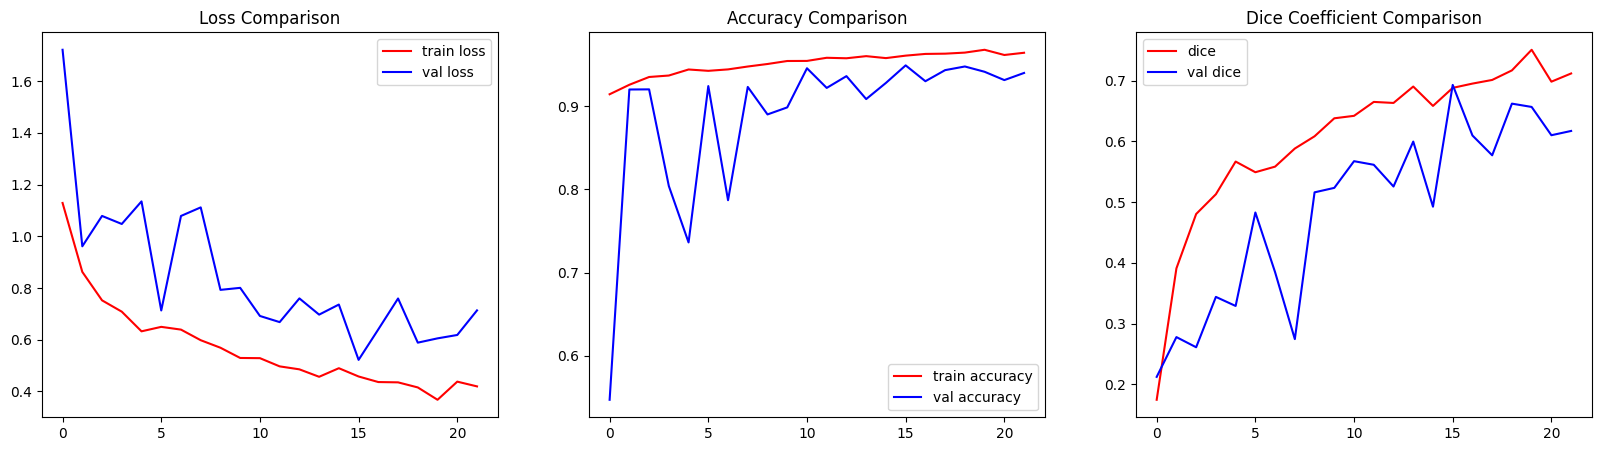

In [ ]:
#Ideja za grafikon preuzeta sa https://colab.research.google.com/github/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb#scrollTo=fKGrAcaOEK4E

fig, axis = plt.subplots(1, 3, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'val loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'val accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

axis[2].plot(results.history["dice_coefficient"], color='r', label='dice')
axis[2].plot(results.history["val_dice_coefficient"], color='b', label='val dice')
axis[2].set_title('Dice Coefficient Comparison')
axis[2].legend()



Iz priloženog, možemo zaključiti sledeće:

Što se tiče **validacionog gubitka**, možemo primetiti da je u početku bio dosta visok (1.72), ali da je kako su epohe prolazile padao i ponovo krenuo da raste i stopirao je kod 0.71, što znači da je model bio nesiguran kod odgovarajućih predikcija (npr prepoznao je da pixel pripada tumoru sa 20% sigurnosti umesto 100%), te možemo zaključiti da ima prostora za poboljšanje. Takođe, možemo zaključiti da je model dostigao overfit (dosta visok accuracy, a visok val_loss), zbog čega se trigerovao early stop mehanizam.

Analogno, za **train_loss** možemo videti da je bio visok (1.2 najveći) u početnim epohama ali je Adam algoritam uspeo da optimizuje parametre tako da bude precizniji i samim tim isti smanji na 0.46, odakle možemo zaključiti da se model dobro pokazao na trening podacima.

Kada pričamo o **train_accuracy**, možemo videti da se on od starta povećavao kako se koja epoha završavala. Konkretno, 88% najniži, 96% najviši, što znači da model poprilično dobro klasifikuje pixele nad trening podacima.

Međutim, za **val_accuracy** možemo videti da se naizmenično povećavala/smanjivala, najniža je bila na 54%, a najviša približno 94%, odakle možemo reći da model dobro vrši klasifikaciju pixela nad validacionim podacima.

Kada pričamo o **dice_coefficient**, možemo videti da je u početku bio poprilično nizak (13%), ali da je na kraju došao do 67% preklapanja sa maskama na trening setu.

Na kraju, za **val_dice** možemo primetiti da je u početku opadao (prvobitno je bio na 21%), a na kraju je bio 61%, što znači da model za taj procenat tačno vrši poklapanja sa ground truth maskom nad validacionom setu.

Iz ovoga možemo zaključiti da model solidno klasifikuje ground truth maske na osnovu originalnih slika, ali da postoji prostora za poboljšanje. Na primer, dataset sa više slika, ili eventualno kombinacija sa još nekim naprednijim tehnikama segmentacije (na primer, SegNet ili DeepLabV3+).

**Evaluacija**

In [ ]:
loss,acc,dice = unet.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9536 - dice_coefficient: 0.6279 - loss: 0.5670


Na osnovu evaluacije, možemo zaključiti sledeće:

Model tačno klasifikuje 95% pixela, ali kao što smo napomenuli, accuracy kao accuracy nije dovoljan i kvalitetan pokazatelj tačnosti modela.

Preklapanja između gt maske i predikciju iznose okvirno 62%.

Loss od 56% ukazuje da model ima još prostora za optimizovanje. Može se desiti da accuracy bude visok ali i da loss bude visok, jer taj loss nije standardni loss, u smislu, taj loss meri nesigurnost modela, ne meri koliko je model pixela loše klasifikovao. Na primer, model je predvideo da neki pixel pripada tumoru, ali je bio vrlo malo siguran u tu predikciju i iz tog razloga je sumirano taj loss te veličine.

In [ ]:
#testiramo kako će se model pokazati nad testnim podacima
preds = unet.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step


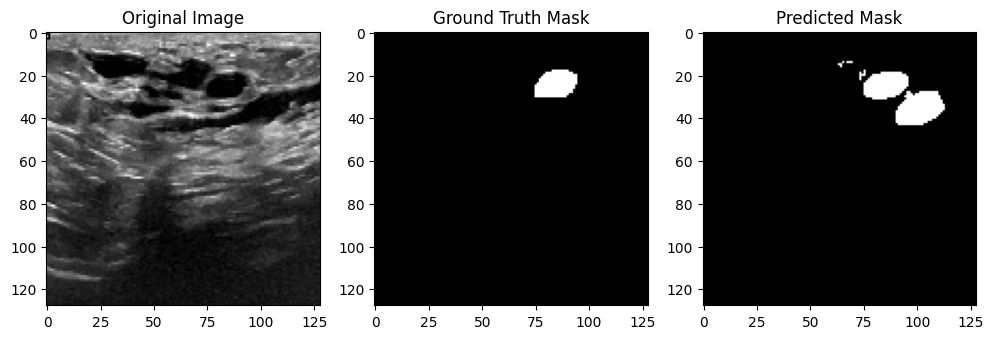

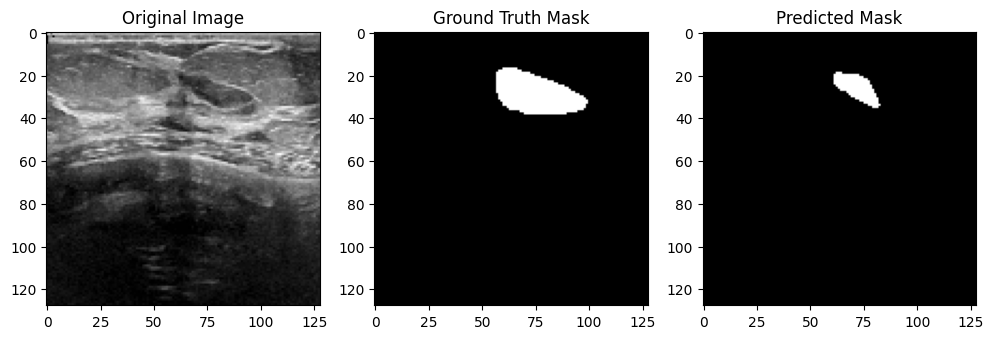

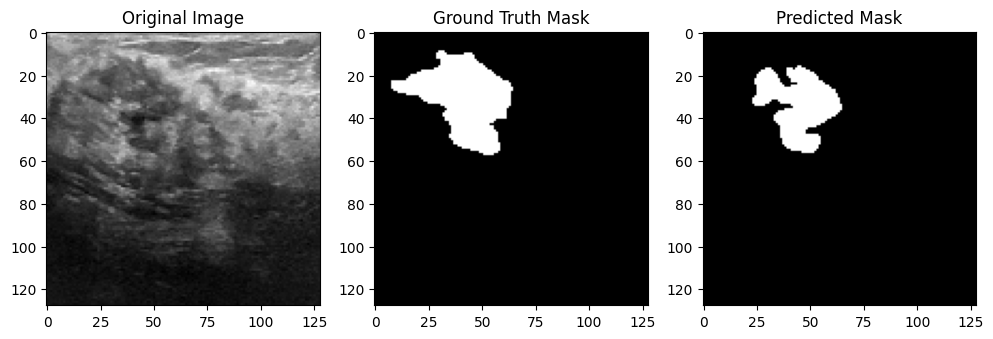

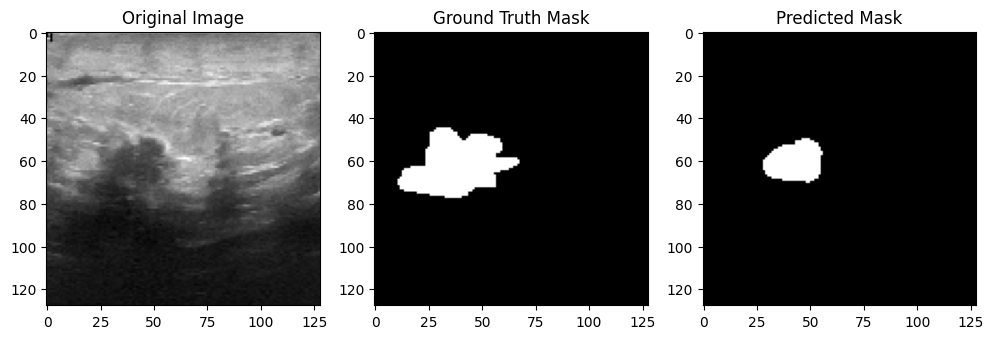

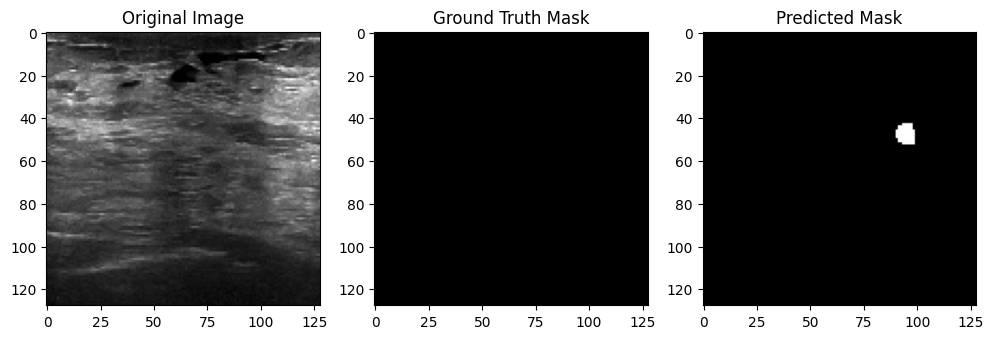

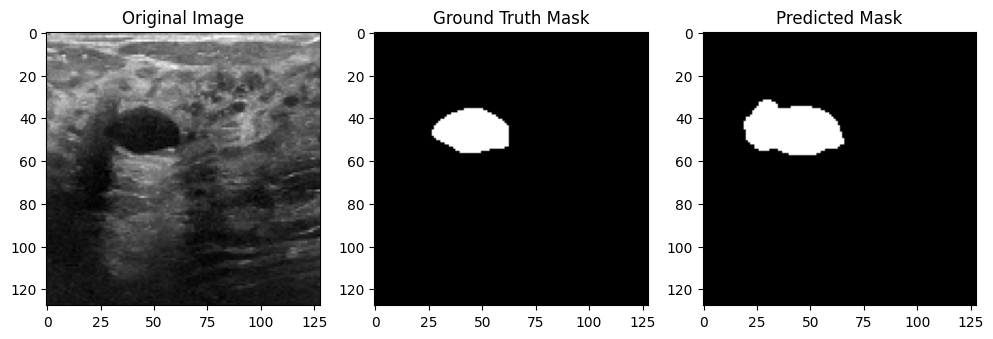

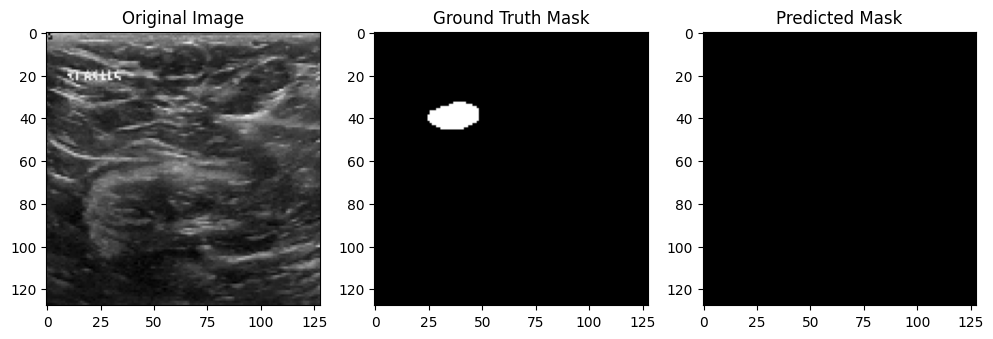

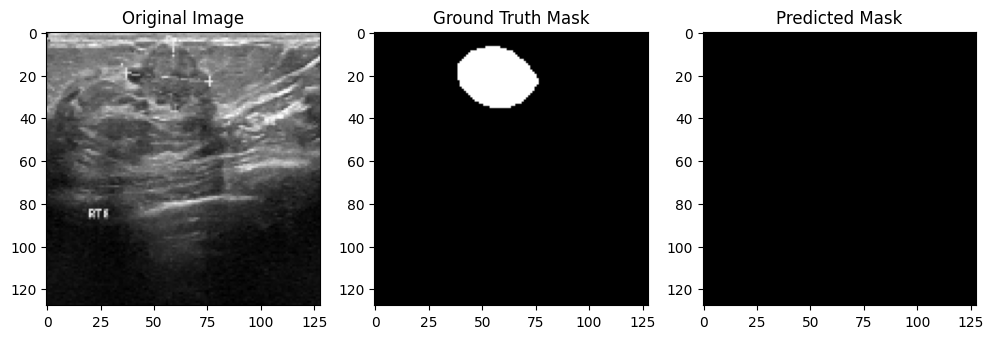

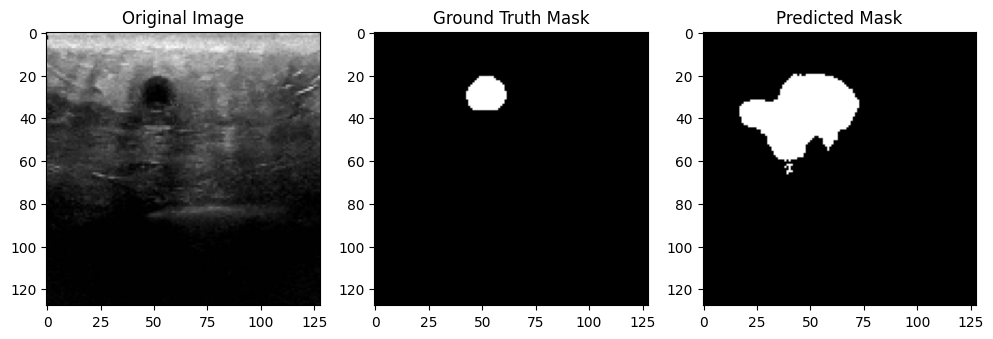

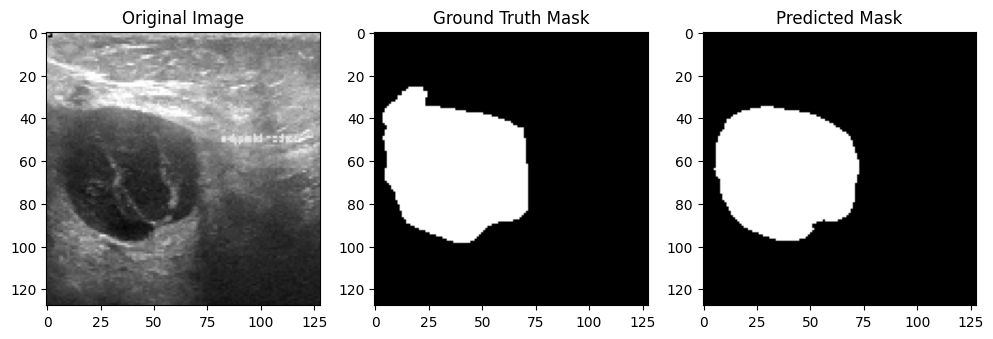

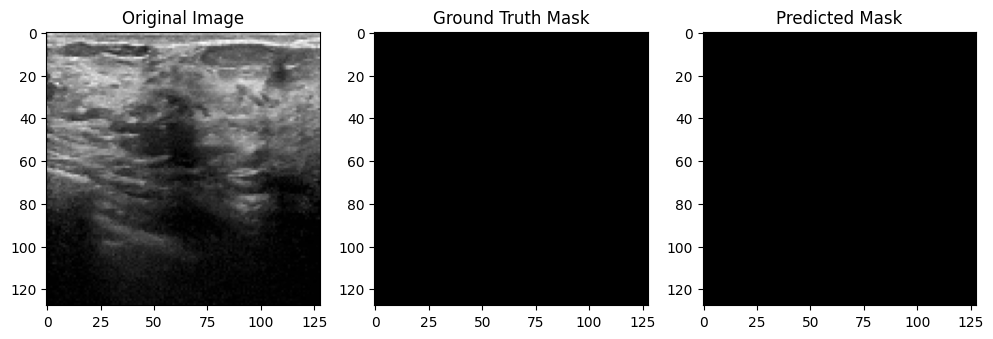

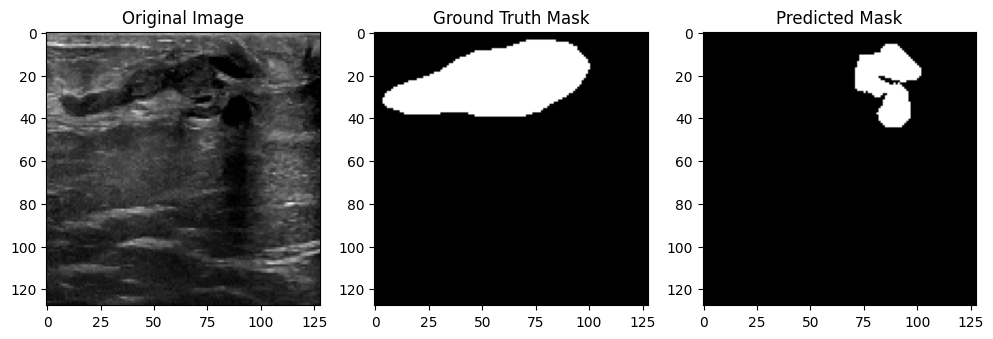

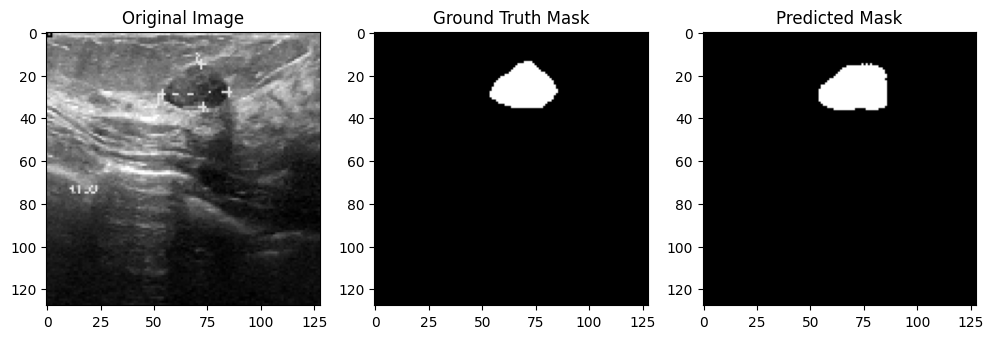

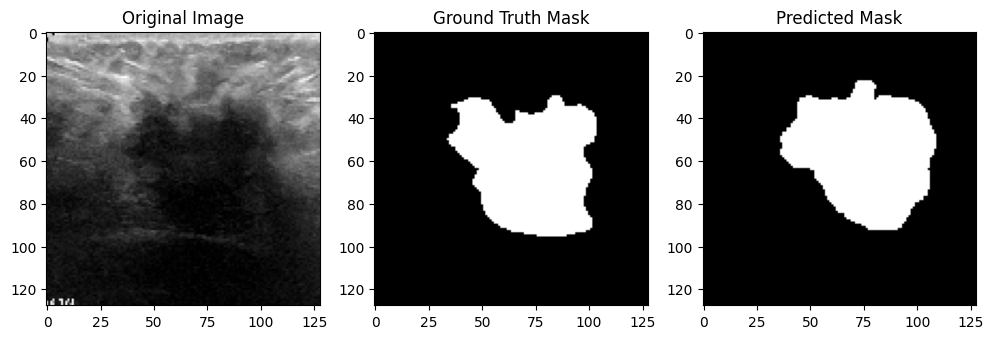

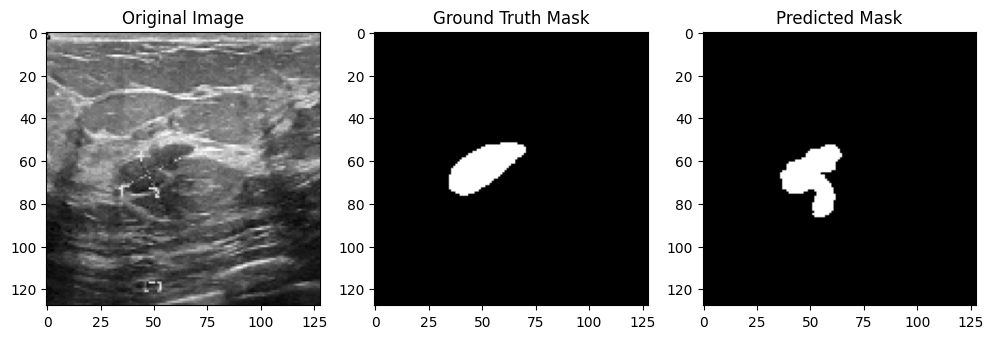

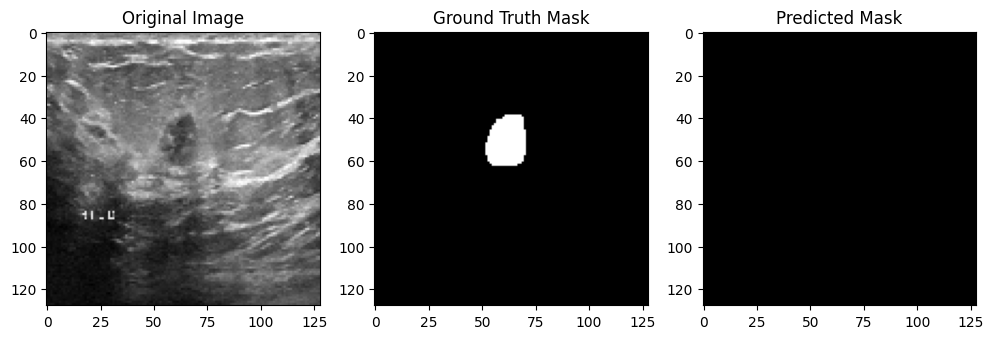

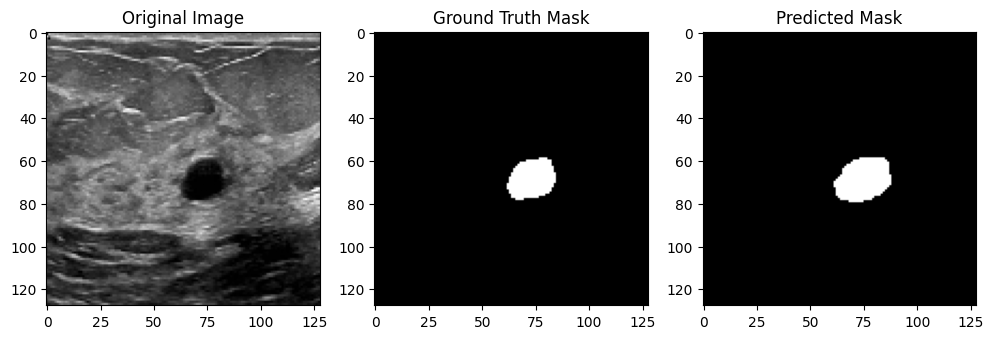

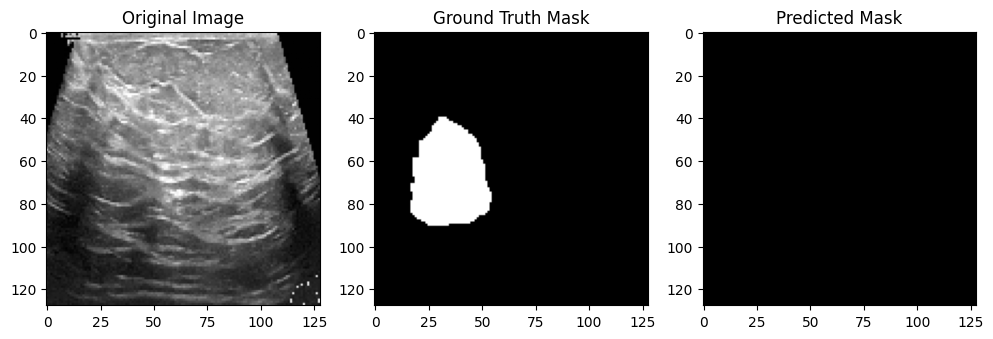

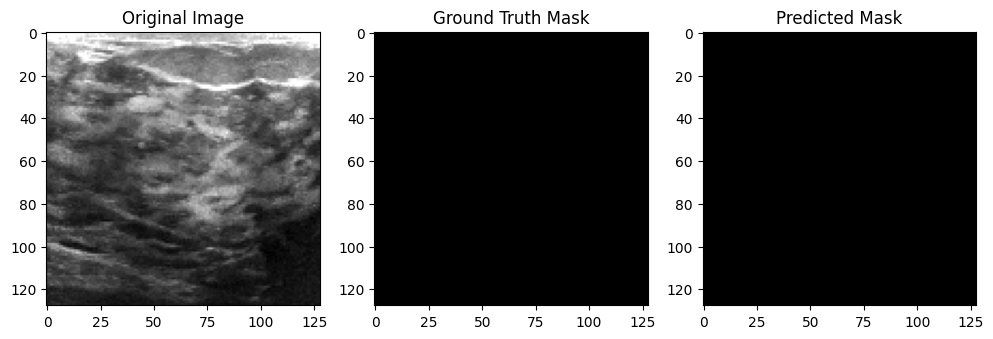

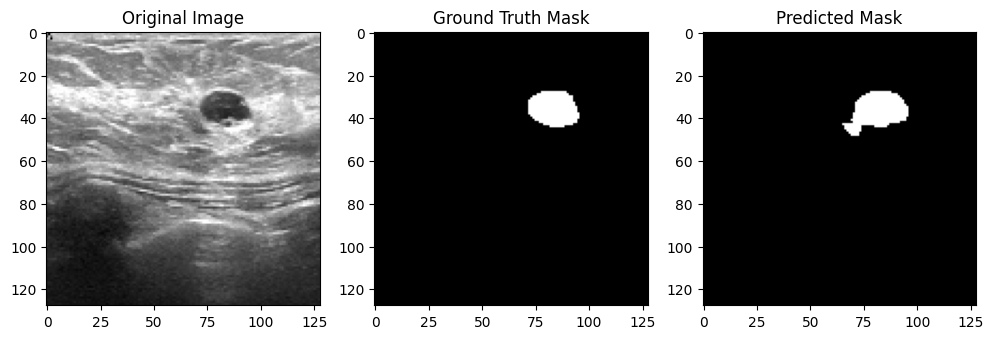

In [ ]:
##prikazaćemo prvih 20 slika
samples = 20
for i in range(samples):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(X_test[i],cmap='gray')             # Prikazujemo originalnu sliku
    plt.title('Original Image')

    plt.subplot(1,3,2)
    plt.imshow(Y_test[i], cmap='gray')             # Prikaz prave (ground truth) maske
    plt.title('Ground Truth Mask')

    plt.subplot(1,3,3)
    plt.imshow(preds[i] > 0.5, cmap='gray')     #koristimo prag od 0.5 za maske, jer želimo da ih prikažemo u crno-beloj nijansi. bez ovoga, maska bi bila kombinovano, nijansa sive i bele
    plt.title('Predicted Mask')
    plt.show()


Iz priloženog, možemo videti da kod nekih slika model skoro pa perfektno odredi masku, ali isto tako ima i situacija gde je ne pogodi uopšte, ili je pogodi delimično. Na primer, u 4-oj slici od dole, možemo tvrditi da je model 99% predvideo tačnu masku, dok je kod 3. slike (takođe) od dole predvideo uopšte.

**Zaključak**

Sve u svemu, možemo tvrditi da je model relativno dobro naučio da segmentira slike i njihove maske, ali i da postoji prostora za poboljšanje. Konkretno, veći dataset, bolji kvalitet slika, složenije tehnike segmentacije i slično.

Segmentacija, konkretno medicinskih fotografija, ima vrlo široku primenu u medicini ali i u mnogim drugim oblastima (npr. kod self-driving cars, gde model razlikuje šta je pešak, šta je kolovoz).